In [1]:
import sys
sys.path.append('../')

# Supervised DR with a Custom Loss

In this example, we'll set up a supervised dimensionality reduction routine based on t-SNE. First, we'll create a paraDime routine for plain parametric t-SNE, which is similar to how the predefined [ParametricTSNE](../api/modules.rst#paradime.routines.ParametricTSNE) is set up. Afterwards, we'll explore the effects of an additional custom loss that takes class label information into account. This additional loss is based on the triplet margin loss.

## The Cover Type Dataset

We will use our custom routine to create embeddings of the forest cover type dataset. This dataset consists of cartographic variables that can be used to predict the type of forest that covers an area. Each data point has 54 attributes and is labeled as one of 7 types of forest.

First, let's import the relevant submodules from paraDime, along with a couple of other packages. We'll take the covertype dataset from sklearn, and we'll also use sklearn's TSNE to see how our parametric verison compares against a non-parametric one.

In [3]:
import numpy as np
import torch
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold
import sklearn.preprocessing
from matplotlib import pyplot as plt

import paradime.dr
import paradime.relations
import paradime.transforms
import paradime.loss
import paradime.utils

paradime.utils.seed.seed_all(42);

In [4]:
covertype = sklearn.datasets.fetch_covtype()

The covertype dataset is highly unbalanced, i.e., it has many more entries for certain classes than others. In this example, we want to use a balanced subset of the dataset. To obtain this subset, we first count how often each class is present. We then invert these counts to compute weights and draw 7000 sample indices with a WeightedRandomSampler, which should lead to a roughly balanced dataset.

In [5]:
_, counts = np.unique(covertype.target, return_counts=True)
weights = np.array([ 1/counts[i-1] for i in covertype.target ])

In [6]:
indices = list(torch.utils.data.WeightedRandomSampler(weights, 7000))

Finally, we standardize the data. Note that in this example we only use the first ten features of the covertype dataset, which are all numerical. The remaining 44 attributes are categorical and would require a slightly special treatment for use with a NN model.

In [7]:
raw_data = covertype.data[indices,:10]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(raw_data)
data = scaler.transform(raw_data)

The class labels in the covertype dataset are integers from 1 to 7. Here's how they map to the actual class names:

In [8]:
label_to_name = {
    1: "Spruce/fir",
    2: "Lodgepole pine",
    3: "Ponderosa pine",
    4: "Cottonwood/willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz",
}

## Regular t-SNE

Now that we have our data ready, let's look at a regular t-SNE of our subset:

In [9]:
tsne = sklearn.manifold.TSNE(perplexity=200, init="pca")
emb = tsne.fit_transform(data)

c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot:>

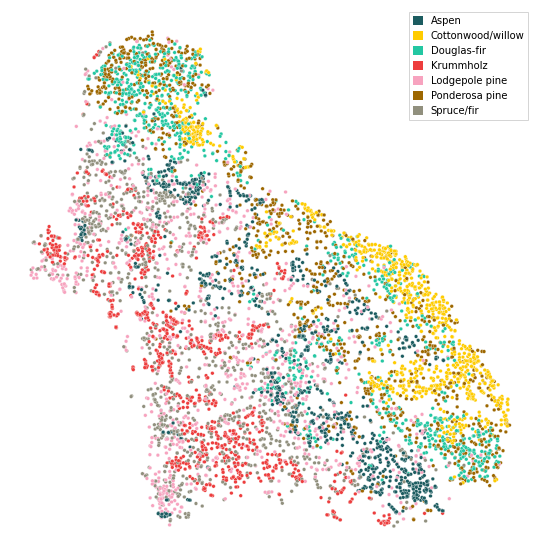

In [10]:
paradime.utils.plotting.scatterplot(emb,
    labels=[ label_to_name[i] for i in covertype.target[indices]],
    legend_options={"loc": 1}
)

While some classes are mixed together quite a bit, we see an overall structure of 'bands' of items that roughly correspond with the classes.

## Unsupervised Parametric t-SNE

Let's now set up a paraDime routine that implements a parametric version of t-SNE.

While older implementations of t-SNE use a full pariwise distance matrix, newer implementations use a neighbor-based approximate distance matrix , similar to UMAP.
In paraDime, [NeighborBasedPDist](../api/modules.rst#paradime.relations.NeighborBasedPDist) implements such an approximate distance matrix, and we use it as global relations here. In t-SNE, the pairiwse distances are rescaled based on a parameter called perplexity. Essentially, distances are transformed to probabilities of neighborhood using a Gaussian kernel, and the kernel width for a given data point is set in such a way that the entropy of the resulting neighborhood distribution matches the binary logarithm of the perplexity. In simple terms, the perplexity can be understood as a smooth measure of how many nearest neighbors are taken into account for the embedding. We use a perplexity value of 200 here. The resulting probability matrix is then symmetrized and normalized.

In [11]:
tsne_global_rel = paradime.relations.NeighborBasedPDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=200, bracket=[0.001, 1000]
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
    ]
)


For the batch-wise relations, t-SNE uses pairwise distances rescaled using a Student's t-distribution (hence the name). The probabilities (this time of neighborhood in the low-dimensional space) are again normalized.

In [12]:
tsne_batch_rel = paradime.relations.DifferentiablePDist(
    transform=[
        paradime.transforms.StudentTTransform(alpha=1.0),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
)


Because t-SNE is usually initialized with PCA, we compute the first two components for our dataset and add the resulting coordinates to the dataset.

In [13]:
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(data)


Finally, we define two training phases: one for the initilaization, using a [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss) on the PCA coordinates; and one for the main embedding, using a [RelationLoss](../api/modules.rst#paradime.loss.RelationLoss) on the global and batch-wise relations (i.e., probabilities). We'll reuse the initialization phase later.

In [14]:
tsne_init = paradime.dr.TrainingPhase(
    name="pca_init",
    loss=paradime.loss.PositionLoss(position_key="pca"),
    batch_size=500,
    epochs=10,
    learning_rate=0.01,
)

tsne_main = paradime.dr.TrainingPhase(
    name="embedding",
    loss=paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div
    ),
    batch_size=500,
    epochs=40,
    learning_rate=0.02,
    report_interval=2,
)

We can now set up our routine and train it:

In [15]:
pd_tsne = paradime.dr.ParametricDR(
    global_relations=tsne_global_rel,
    batch_relations=tsne_batch_rel,
    in_dim=10,
    out_dim=2,
    hidden_dims=[100,50],
    dataset=data,
    use_cuda=True,
    verbose=True,
)
pd_tsne.add_to_dataset({"pca": pca})
pd_tsne.add_training_phase(tsne_init)
pd_tsne.add_training_phase(tsne_main)

pd_tsne.train()

2022-08-29 17:58:50,877: Registering dataset.
2022-08-29 17:58:51,021: Adding entry 'pca' to dataset.
2022-08-29 17:58:51,022: Computing global relations 'rel'.
2022-08-29 17:58:51,023: Indexing nearest neighbors.
2022-08-29 17:59:22,365: Calculating probabilities.
2022-08-29 17:59:23,893: Beginning training phase 'pca_init'.
2022-08-29 17:59:25,989: Loss after epoch 0: 11.94074472784996
2022-08-29 17:59:26,502: Loss after epoch 5: 0.014664334536064416
2022-08-29 17:59:26,904: Beginning training phase 'embedding'.
2022-08-29 17:59:29,878: Loss after epoch 0: 0.05023349029943347
2022-08-29 17:59:36,227: Loss after epoch 2: 0.04354745661839843
2022-08-29 17:59:42,606: Loss after epoch 4: 0.04269221075810492
2022-08-29 17:59:48,652: Loss after epoch 6: 0.042116041760891676
2022-08-29 17:59:54,983: Loss after epoch 8: 0.04153931373730302
2022-08-29 18:00:01,301: Loss after epoch 10: 0.04116900800727308
2022-08-29 18:00:07,467: Loss after epoch 12: 0.040751771070063114
2022-08-29 18:00:13,6

Once the trianing has completed we can visualize our parametric t-SNE of the covertype subset:

<AxesSubplot:>

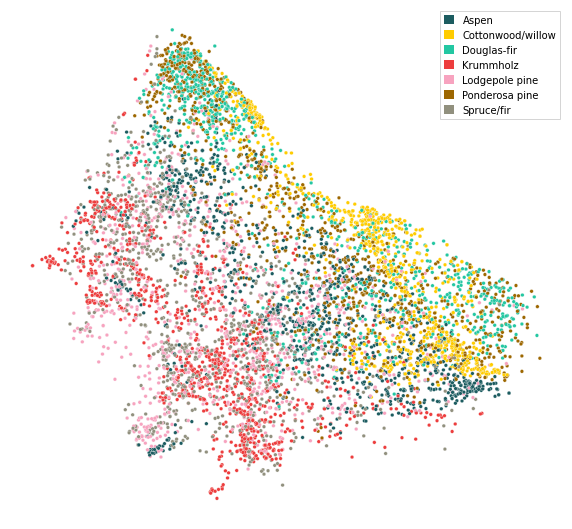

In [16]:
paradime.utils.plotting.scatterplot(
    pd_tsne.apply(data),
    labels=[label_to_name[i] for i in covertype.target[indices]],
    legend_options={"loc": 1}
)

Notice how the overall shape and banding structure is very similar to the "exact" t-SNE.

## Supervised Parametric t-SNE

Since the class clusters overlap quite strongly, we would like to see if we can make them a bit more compact by introducing a supervision in our routine. This will make use of the class labels to artificially separate the class clusters.

One promising type of loss for this task is the so-called triplet loss. It basically looks at triplets of datapoints, where one datapoint is the so called anchor, one is a *positive* example (with the same label as the anchor), and one a *negative* example (with a different label). The loss then tries to maximize the difference of the distance between anchor and positive, and anchor and negative examples. This essentiall pulls points with equal labels closer together, while pushing points with different labels further apart.

The triplet loss is implemented in PyTorch as [TripletMarginLoss](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html). To make use of it in a paraDime routine, we have to make sure it is applied correctly to triplets of data samples. We do this by writing a custom [Loss](../api/modules.rst#paradime.loss.Loss) class:

In [17]:
class TripletLoss(paradime.loss.Loss):
    """Triplet loss for supervised DR.
    
    To be used with negative edge sampling with sampling rate 1.
    """

    def __init__(self, margin=1.0, name=None):
        super().__init__(name)

        self.margin = margin

    def forward(self, model, global_relations,  batch_relations, batch, device):
        
        data = batch['from_to_data'].to(device)
        # data consists of [[a0, a0, a1, a1, ...], [p0, n0, p1, n1, ...]]

        anchor = model(data[0,::2])
        positive = model(data[1,::2])
        negative = model(data[1,1::2])

        loss = torch.nn.TripletMarginLoss(margin=self.margin)
        
        return loss(anchor, positive, negative)

In a custom paraDime [Loss](../api/modules.rst#paradime.loss.Loss), we basically only have to define a `forward` method for the loss with a given call signature. As explained in the section about [Building Blocks of a paraDime Routine](building_blocks.rst), the loss gets passed the model, the computed global relation data, the batch-relation "recipes", the batch of data, and the device on which the model lives. To obtain triplets, we can make use of the negative edge sampling provided by paraDime. A batch of negative-edge sampled dataconsists of 1 + *n* copies of each data point, together with one actually neighboring sample and *n* non-neighboring samples (*n* is the negative sampling rate). Whether or not two data points are consideres as neighbors is governed by a some global relations between data points. If we construct our negative edge sampler with a negative samplnig rate of 1 and with the correct relations, we'll obtain triplets directly in the batch's `'from_to_data'` attribute.

Let's now construct these relations separately. In our case, two datapoints should be considered "neighbors" if they have the same target label. We'll construct a matrix of zeros and ones for our data subset, where 1 means "same label" and 0 means "different label":

In [18]:
labels = covertype.target[indices]

same_label = (np.outer(labels, np.ones_like(labels))
    - np.outer(np.ones_like(labels), labels) == 0).astype(float)

All that's left to do now is to:
 1. Add the above relations as a second global relation entry to our routine (we can use the [Precomputed](../api/modules.rst#paradime.relations.Precomputed) relations interface);
 2. configure our main training phase to use negative edge sampling;
 3. tell it to use the above relations as a basis for sampling; and
 4. change the loss from a pure t-SNE loss to a [CompoundLoss](../api/modules.rst#paradime.loss.CompoundLoss) with our `TripletLoss`.

In [21]:
super_tsne = paradime.dr.ParametricDR(
    global_relations={
        "tsne": tsne_global_rel,
        "same_label": paradime.relations.Precomputed(same_label),
    },
    batch_relations=tsne_batch_rel,
    in_dim=10,
    out_dim=2,
    hidden_dims=[100, 50],
    dataset=data,
    use_cuda=True,
    verbose=True,
)
super_tsne.add_to_dataset({"pca": pca})
super_tsne.add_training_phase(tsne_init)
super_tsne.add_training_phase(
    name="embedding",
    loss=paradime.loss.CompoundLoss(
        [
            paradime.loss.RelationLoss(
                loss_function=paradime.loss.kullback_leibler_div,
                global_relation_key="tsne",
            ),
            TripletLoss(),
        ],
        weights=[700, 1],
    ),
    sampling="negative_edge",
    neg_sampling_rate=1,
    edge_rel_key="same_label",
    batch_size=300,
    epochs=40,
    learning_rate=0.02,
    report_interval=2,
)
super_tsne.train()


2022-08-29 18:02:35,603: Registering dataset.
2022-08-29 18:02:35,607: Adding entry 'pca' to dataset.
2022-08-29 18:02:35,608: Computing global relations 'tsne'.
2022-08-29 18:02:35,610: Indexing nearest neighbors.
2022-08-29 18:02:51,156: Calculating probabilities.
2022-08-29 18:02:52,251: Computing global relations 'same_label'.
2022-08-29 18:02:52,253: Beginning training phase 'pca_init'.
2022-08-29 18:02:52,383: Loss after epoch 0: 10.884016886353493
2022-08-29 18:02:52,921: Loss after epoch 5: 0.017522570269647986
2022-08-29 18:02:54,300: Beginning training phase 'embedding'.
2022-08-29 18:02:57,080: Loss after epoch 0: 32.01246237754822
2022-08-29 18:03:02,713: Loss after epoch 2: 30.349495887756348
2022-08-29 18:03:08,357: Loss after epoch 4: 30.006397485733032
2022-08-29 18:03:13,923: Loss after epoch 6: 30.011822938919067
2022-08-29 18:03:19,592: Loss after epoch 8: 30.31546378135681
2022-08-29 18:03:25,212: Loss after epoch 10: 30.108312368392944
2022-08-29 18:03:30,957: Loss

The only tricky part here is to set the correct weight for each loss component in the compound loss. One way to do this is to start with some best guess for the weights, train the routine, and then inspect both the total loss's and the individual losses' histories. You can access the history of the total loss via `super_tsne.training_phases[1].loss.history` and of the individual losses via `super_tsne.training_phases[1].loss.losses[i].history`.

<AxesSubplot:>

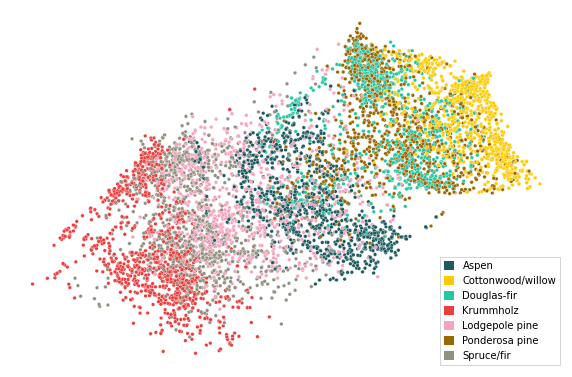

In [23]:
paradime.utils.plotting.scatterplot(
    super_tsne.apply(data),
    labels=[label_to_name[i] for i in covertype.target[indices]],    
)

Clearly, the triplet loss pulled apart the different classes, while the overall structure (the "bands" and their relative ordering) was preserved due to the compound loss with the t-SNE component.